# CEO-Request Challenge

## Problem statement (summarized)

How should Olist improve it's profit margin, given that it has
- revenues per sellers per months
- revenues per orders
- reputation costs (estimated) per bad reviews
- operational costs of IT system that grows with number of orders, but not linearly (scale effects)

In [ ]:
%load_ext autoreload
%autoreload 2
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from olist.seller import Seller
from olist.order import Order
from olist.data import Olist


order = Order()
orders_data = order.get_training_data()
seller = Seller()
sellers_data = seller.get_training_data()
data = Olist().get_data()


working_data = data.copy()
orders = working_data['orders']
sellers = working_data['sellers']
order_items = working_data['order_items']
order_reviews = working_data['order_reviews']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Review Data

## Review Seller Activity

<AxesSubplot:xlabel='order_approved_at', ylabel='Count'>

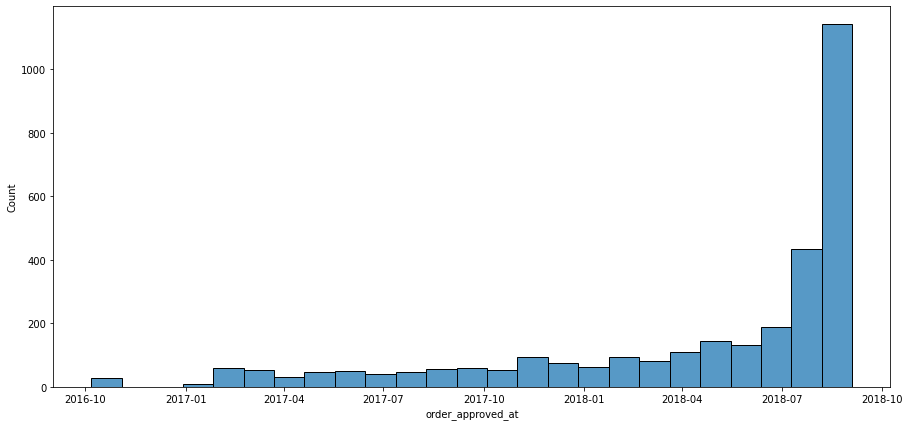

In [ ]:
# Join sellers to orders, group by seller, find max 'order apprived at' (latest order)
seller_last_ship = pd.merge(orders[['order_id','order_approved_at']],
                            order_items[['order_id','seller_id']], on='order_id').groupby('seller_id').max().reset_index()


plt.figure(figsize=(15,7))
sns.histplot(data=seller_last_ship['order_approved_at'])

## Review Olist Activity

<AxesSubplot:xlabel='order_approved_at', ylabel='Count'>

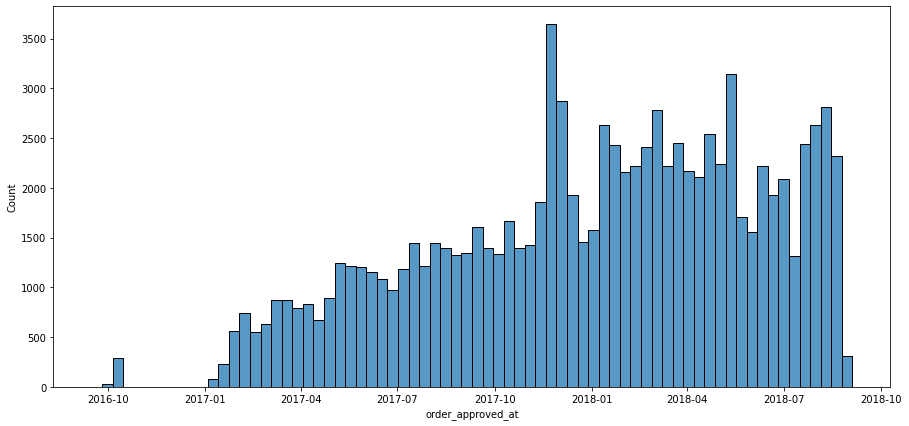

In [ ]:
plt.figure(figsize=(15,7))
sns.histplot(data=orders['order_approved_at'])

# Revise Data

## Reduce Data to Last 3 Months

In [ ]:
# Last approved order in data - 3 month time delta

orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
active_cutoff = pd.to_datetime(orders['order_approved_at']).max() - timedelta(days=3*30.437)

# Filter out older orders
active_orders=(orders[orders['order_approved_at'] > active_cutoff])
active_sellers_orders = pd.merge(active_orders,order_items, on='order_id')

# Create active sellers dataset
active_sellers = active_sellers_orders.groupby('seller_id').count().reset_index()[['seller_id','order_id']]
active_sellers.columns = ['seller_id', 'order_count']

len(active_sellers)

1808

## Compare Active Sellers to Original 

In [ ]:
# get all sellers
all_sellers = pd.merge(orders,order_items, on='order_id').groupby('seller_id').count().reset_index()\
[['seller_id','order_id']]
all_sellers.columns = ['seller_id', 'order_count']


#compare all sellers list to active 
active_seller_ratio = len(active_sellers) / len(all_sellers)*100
active_seller_ratio


58.41680129240711

# Seller Analysis

## Costs

In [ ]:
cost_dict = {1:100, 2:50, 3:40, 4:0, 5:0}

# get reviews scores per order
review_scores = order.get_review_score()[['order_id','review_score']]

# get seller-order relationship
order_seller = active_sellers_orders[['order_id','seller_id']]

# merge data
order_seller_reviews = pd.merge(order_seller, review_scores, on = 'order_id').dropna()

#group by seller and review score
order_seller_reviews_grouped = order_seller_reviews.groupby(['seller_id','review_score']).count().reset_index()
seller_review_cost = order_seller_reviews_grouped.rename({'order_id':'number_of'}, axis = 'columns')

#map costs to reviews
seller_review_cost['review_cost_unit'] = seller_review_cost['review_score'].map(cost_dict)

#calulate total costs for seller
seller_review_cost['seller_cost'] = seller_review_cost['review_cost_unit']*seller_review_cost['number_of']

#sum review costs
seller_costs = seller_review_cost.groupby(['seller_id']).sum().reset_index()[['seller_id', 'seller_cost']]

## Include  Revenue

In [ ]:
# get reviews scores per order
review_scores = order.get_review_score()[['order_id','review_score']]

# get seller-order relationship
order_seller = active_sellers_orders[['order_id','seller_id']]

# merge data
order_seller_reviews = pd.merge(order_seller, review_scores, on = 'order_id').dropna()

#group by seller and review score
order_seller_reviews_grouped = order_seller_reviews.groupby(['seller_id','review_score']).count().reset_index()
seller_review_cost = order_seller_reviews_grouped.rename({'order_id':'number_of'}, axis = 'columns')

#map costs to reviews
seller_review_cost['review_cost_unit'] = seller_review_cost['review_score'].map(cost_dict)

#calulate total costs for seller
seller_review_cost['seller_cost'] = seller_review_cost['review_cost_unit']*seller_review_cost['number_of']

#sum review costs
seller_costs = seller_review_cost.groupby(['seller_id']).sum().reset_index()[['seller_id', 'seller_cost']]

In [ ]:
# Revenue 
seller_revenue = pd.merge(active_sellers_orders[['seller_id','order_id']],order_items[['order_id','price']], on='order_id')\
.groupby('seller_id').sum().reset_index()
seller_revenue.columns = ['seller_id','revenue']


seller_order_count = pd.merge(active_sellers_orders[['seller_id','order_id']],order_items[['order_id']], on='order_id')\
.groupby('seller_id').count().reset_index()

seller_order_count.columns = ['seller_id', 'order_count']
seller_revenue['order_count'] = seller_order_count['order_count'] 
seller_econ_summary = pd.merge(seller_revenue,seller_costs, on='seller_id')
seller_econ_summary['revenue_per_order'] = seller_econ_summary['revenue'] / seller_econ_summary['order_count']
seller_econ_summary['olist_net_on_seller'] = seller_econ_summary['revenue']*0.1 + 3*80- seller_econ_summary['seller_cost']
seller_econ_summary['olist_sale_take'] = seller_econ_summary['revenue']*0.1


In [ ]:
#IT costs

#approved ordrs list

approved_list = ['delivered','approved']
order_status = working_data['orders'][['order_status']]
orders_approved = order_status[order_status.isin(approved_list)]

# number of approved orders, including shipped as approved 
orders_approved_count = len(orders_approved)


#total IT cost
IT_cost_cumulative = 500000

#total IT cost coef
IT_cost_coef = IT_cost_cumulative / (orders_approved_count)**0.5

IT_cost_coef

projected_yearly_sales = 2900*4
next_year_IT_cost = IT_cost_coef * (orders_approved_count+projected_yearly_sales)**0.5 - IT_cost_coef * (orders_approved_count)**0.5

order_unit_cost = next_year_IT_cost/(projected_yearly_sales)
order_unit_cost

seller_econ_projected = seller_econ_summary[['seller_id','order_count','olist_net_on_seller']].copy()

seller_econ_projected['projected_seller_profitabilty'] = seller_econ_projected['olist_net_on_seller'] - seller_econ_projected['order_count']*order_unit_cost

seller_econ_projected = seller_econ_projected.drop(axis=1, labels=['order_count','olist_net_on_seller'])\
.sort_values('projected_seller_profitabilty').reset_index(drop=True)


In [ ]:
projected_yearly_sales = 2900*4
next_year_IT_cost = IT_cost_coef * (orders_approved_count+projected_yearly_sales)**0.5 - IT_cost_coef * (orders_approved_count)**0.5

In [ ]:
order_unit_cost = next_year_IT_cost/(projected_yearly_sales)
order_unit_cost

2.4447241176637835

In [ ]:
seller_econ_projected = seller_econ_summary[['seller_id','order_count','olist_net_on_seller']].copy()

seller_econ_projected['projected_seller_profitabilty'] = seller_econ_projected['olist_net_on_seller'] - seller_econ_projected['order_count']*order_unit_cost

seller_econ_projected = seller_econ_projected.drop(axis=1, labels=['order_count','olist_net_on_seller'])\
.sort_values('projected_seller_profitabilty').reset_index(drop=True)


<AxesSubplot:ylabel='projected_seller_profitabilty'>

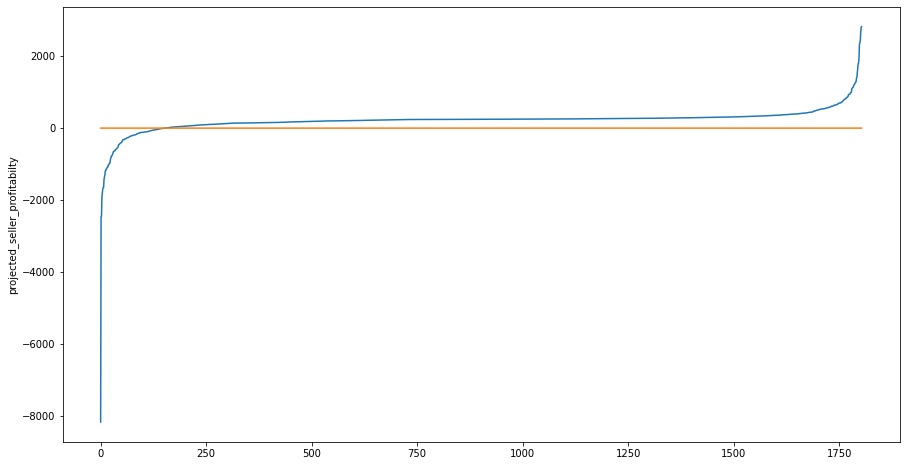

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data = seller_econ_projected, x=seller_econ_projected.index, y='projected_seller_profitabilty')
sns.lineplot(y = 0, x = range(len(seller_econ_projected)))

(-2000.0, 2000.0)

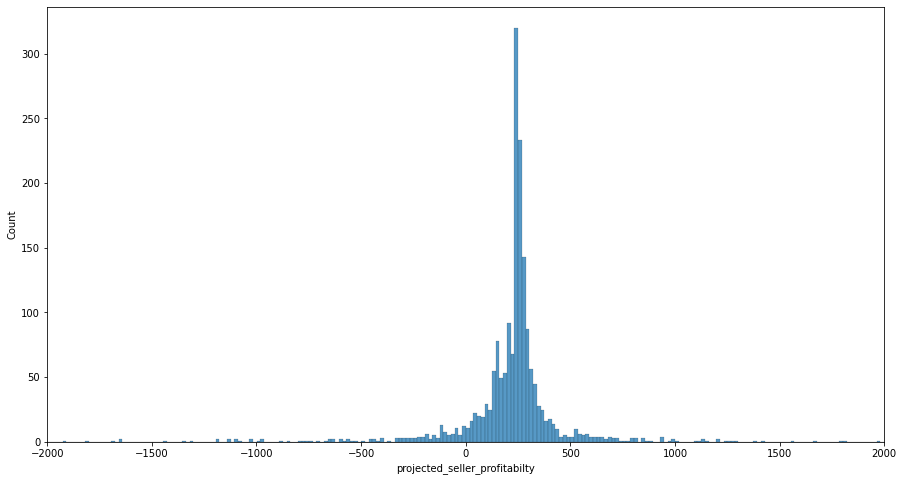

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data = seller_econ_projected['projected_seller_profitabilty'])
plt.xlim(-2000, 2000)


In [ ]:
seller_econ_summary_sorted = seller_econ_summary.sort_values(by='olist_net_on_seller').reset_index(drop=True)

In [ ]:
def IT_cost(num_orders):
    return IT_cost_coef*((orders_approved_count+num_orders)**0.5-orders_approved_count**0.5)
    

In [ ]:
profit_list=[]
for i in range(len(seller_econ_summary_sorted)):
    profit = seller_econ_summary_sorted['olist_net_on_seller'].iloc[i:].sum() - IT_cost(seller_econ_summary_sorted['order_count'].iloc[i:].sum())
    profit_list.append(profit)
    

<AxesSubplot:>

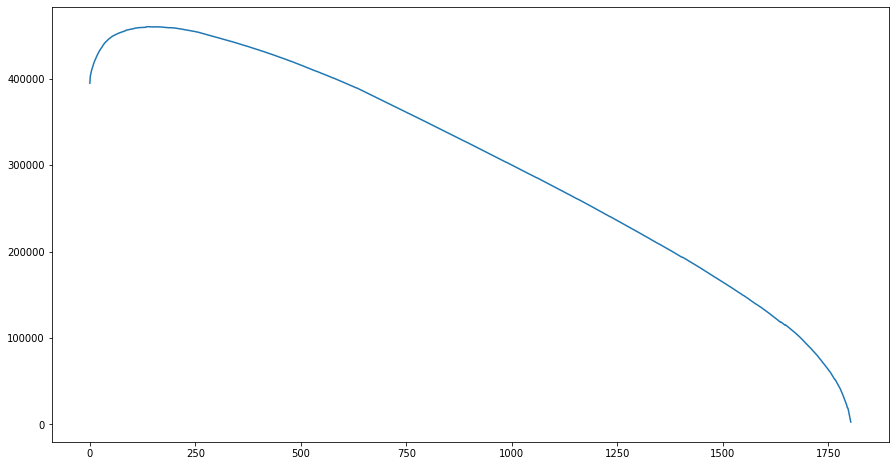

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y=profit_list, x=range(len(profit_list)))

In [ ]:

profit_list.index(max(profit_list))

136

In [ ]:
max(profit_list)

460026.1758164776